# Baseball Data: a thorough analysis 
#### A data set containing complete batting and pitching statistics from 1871 to 2014, plus fielding statistics, standings, team stats, managerial records, post-season data, and more. 

#### the data is available at: http://www.seanlahman.com/baseball-archive/statistics/

### Focus of our analysis
#### Our analysis will focus on players salaries:
- What is the salary evolution?
- Were different teams awarded different salaries?
    - were the difference justified?
- Did awarded players earn more on average?
- What was the influence of appearances on salary?
- Did the college attended influence salary of players?
- Were the players with the best statistics awarded the with the best salaries?

### Packages needed

In [1]:
# Import General Packages
import numpy as np
import pandas as pd

# Import plotting/graphics packages
import matplotlib.pyplot as plt
import seaborn as sns 

# Graphics inline 
%matplotlib inline

### Importing the datasets of interest 

Main tables:
- MASTER - Player names, DOB, and biographical info
- Batting - batting statistics
- Pitching - pitching statistics
- Fielding - fielding statistics


Supplemented by theses tables 
- Teams - yearly stats and standings 
- Salaries - player salary data
- AwardsPlayers - awards won by players
- AwardsSharePlayers - award voting for player awards
- Appearances - details on the positions a player appeared at
- Schools - list of colleges that players attended
- CollegePlaying - list of players and the colleges they attended

In [2]:
master = pd.read_csv('baseballdatabank-2017.1/core/Master.csv')
batting = pd.read_csv('baseballdatabank-2017.1/core/Batting.csv')
pitching = pd.read_csv('baseballdatabank-2017.1/core/Pitching.csv')
fielding = pd.read_csv('baseballdatabank-2017.1/core/Fielding.csv')
teams = pd.read_csv('baseballdatabank-2017.1/core/Teams.csv')
salaries = pd.read_csv('baseballdatabank-2017.1/core/Salaries.csv')
awardPlayers = pd.read_csv('baseballdatabank-2017.1/core/AwardsPlayers.csv')
awardsSharePlayers = pd.read_csv('baseballdatabank-2017.1/core/AwardsSharePlayers.csv')
appearances = pd.read_csv('baseballdatabank-2017.1/core/Appearances.csv')
schools = pd.read_csv('baseballdatabank-2017.1/core/Schools.csv')
collegePlaying = pd.read_csv('baseballdatabank-2017.1/core/CollegePlaying.csv')

### External Data ###
#### Consumer Price Index from: https://data.bls.gov/timeseries/
I assume that the data for salaries is not adjusted to inflation (since no information could be found in the documentation). Therefore, we are going to adjust our salary data to inflation.

In [3]:
cpi_data = pd.read_excel('cpi_usa_85_2016.xlsx', header=10, index_col=None)

In [4]:
cpi_data.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
27,2012,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601,228.850,230.338
28,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049,232.366,233.548
29,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812,236.384,237.088
30,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525,236.265,237.769
31,2016,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432,238.778,241.237


In [5]:
#Taking the average of HALF1 and HALF 2 to form a yearly CPI
yearly_cpi = pd.DataFrame({'Year': cpi_data.Year,'inflation':(cpi_data.HALF1+cpi_data.HALF2)/2}) 

In [6]:
yearly_cpi.tail()

,Year,inflation
27,2012,229.5940
28,2013,232.9570
29,2014,236.7360
30,2015,237.0170
31,2016,240.0075


### Let's adjust our data to inflation 

In [7]:
dict_inflation = dict(zip(yearly_cpi.Year, yearly_cpi.inflation));

In [8]:
salaries['CPI'] = salaries['yearID'].map(dict_inflation)

In [9]:
cpi_2016 = yearly_cpi[yearly_cpi['Year']==2016]['inflation'].values[0]

In [10]:
salaries.head()

,yearID,teamID,lgID,playerID,salary,CPI
0,1985,ATL,NL,barkele01,870000,107.55
1,1985,ATL,NL,bedrost01,550000,107.55
2,1985,ATL,NL,benedbr01,545000,107.55
3,1985,ATL,NL,campri01,633333,107.55
4,1985,ATL,NL,ceronri01,625000,107.55


In [123]:
salaries['salary_adj'] = (salaries['salary']/salaries['CPI'])*cpi_2016

In [138]:
mean_salary_pa_adj = salaries.groupby(['yearID']).mean()['salary_adj']
median_salary_pa_adj = salaries.groupby(['yearID']).median()['salary_adj']
max_salary_pa_adj = salaries.groupby(['yearID']).max()['salary_adj']
top_quartile_pa_adj1 = salaries.groupby\
                               ('yearID', group_keys=False).apply\
                               (lambda g: g[g.salary_adj>= g.salary_adj.quantile(0.75)]).reset_index(drop=True)
top_quartile_pa_adj = top_quartile_pa_adj1.groupby('yearID')['salary_adj'].mean()

# Salary data, graphical analysis

In [139]:
mean_salary_pa = salaries.groupby(['yearID']).mean()['salary']
median_salary_pa = salaries.groupby(['yearID']).median()['salary']
max_salary_pa = salaries.groupby(['yearID']).max()['salary']
top_quartile_pa1 = salaries.groupby\
                               ('yearID', group_keys=False).apply\
                               (lambda g: g[g.salary>= g.salary.quantile(0.75)]).reset_index(drop=True)
top_quartile_pa = top_quartile_pa1.groupby('yearID')['salary'].mean()

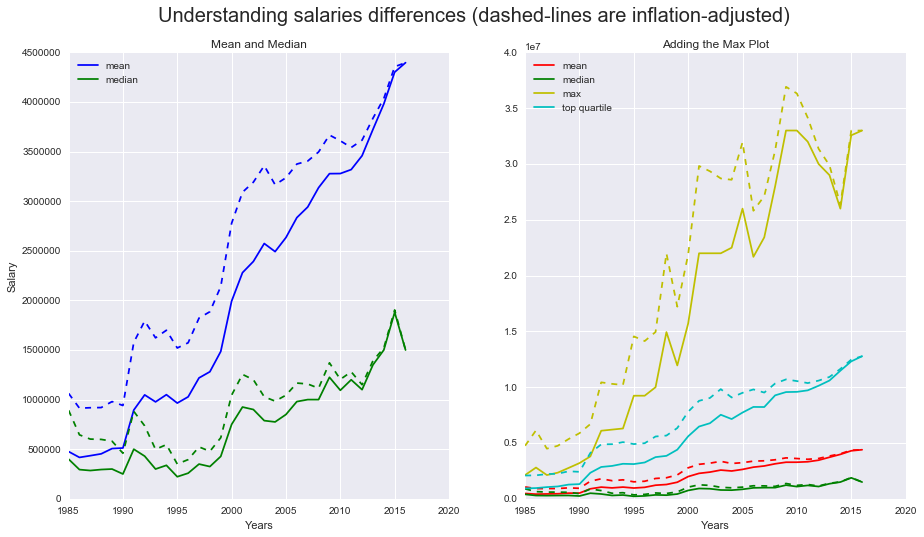

In [140]:
plt.figure(figsize=(15,8)) 
plt.suptitle('Understanding salaries differences (dashed-lines are inflation-adjusted)', fontsize=20)

plt.subplot(1, 2, 1)
plt.plot(mean_salary_pa, label='mean', c='blue')
plt.plot(mean_salary_pa_adj, ls='--',c='blue', label='')
plt.plot(median_salary_pa, label='median', c='green')
plt.plot(median_salary_pa_adj, label='', c='green', ls='--')

plt.legend(loc='upper left')
plt.xlabel('Years')
plt.ylabel('Salary')
plt.title('Mean and Median')

plt.subplot(1, 2, 2)
plt.plot(mean_salary_pa, label='mean', c='r')
plt.plot(mean_salary_pa_adj, label='', c='r', ls='--')
plt.plot(median_salary_pa, label='median', c='g')
plt.plot(median_salary_pa_adj, label='', c='g', ls='--')
plt.plot(max_salary_pa, label='max', c='y')
plt.plot(max_salary_pa_adj, label='', c='y', ls='--')
plt.plot(top_quartile_pa, label='top quartile', c='c')
plt.plot(top_quartile_pa_adj, label='', c='c', ls='--')
plt.legend(loc='upper left')
plt.xlabel('Years')
plt.title('Adding the Max Plot')

#### Histogram of salary

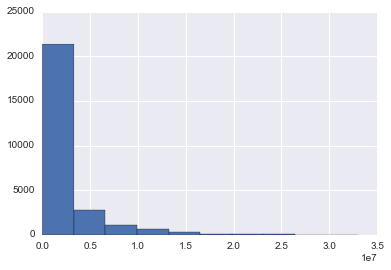

In [141]:
salaries.salary.hist()

#### First let's note that the data for the salaries is spanning from 1985 to 2016, unlike other datasets
- the inflation adjusted data does not change the trends so we will continue with the nominal data 
- the spread between mean an median increases at a fast rate 
- so we need a better understanding of the difference between average/median and maximum values. Since there are huge inequalities between players, what are the reasons:
    - skills?
    - college?
    - team?
    - but the first step would be to understand the origin of the maximum values

### Understanding highest salaries

We shall look at the highest salaries per year and not overall because of salaries evolution, we would only get data in the latest years.

In [142]:
top_1pct_salaries_per_annum = salaries.groupby\
                               ('yearID', group_keys=False).apply\
                               (lambda g: g[g.salary>= g.salary.quantile(0.99)]).reset_index(drop=True)

In [145]:
top_1pct_salaries_per_annum.head()

,yearID,teamID,lgID,playerID,salary,CPI,salary_adj
0,1985,ATL,NL,murphda05,1625000,107.55,3.626334e+06
1,1985,NYA,AL,winfida01,1795704,107.55,4.007275e+06
2,1985,NYN,NL,cartega01,2028571,107.55,4.526939e+06
3,1985,NYN,NL,fostege01,1942857,107.55,4.335660e+06
4,1985,PHI,NL,schmimi01,2130300,107.55,4.753956e+06


In [150]:
teams_top_salaries=[]
teams_no_top_salaries=[]

In [151]:
for team in salaries.teamID.unique():
    if team in top_1pct_salaries_per_annum.teamID.unique():
        teams_top_salaries.append(team)
    else:
        teams_no_top_salaries.append(team)

In [152]:
print "- Number of teams without top salaries (best 5% salaries) players: ",len(teams_no_top_salaries)
print "- Number of teams with top salaries players:", len(teams_top_salaries)

- Number of teams without top salaries (best 5% salaries) players:  12
- Number of teams with top salaries players: 34


### Who are these top paid players?

In [153]:
top_1pct_salaries_per_annum.head()

,yearID,teamID,lgID,playerID,salary,CPI,salary_adj
0,1985,ATL,NL,murphda05,1625000,107.55,3.626334e+06
1,1985,NYA,AL,winfida01,1795704,107.55,4.007275e+06
2,1985,NYN,NL,cartega01,2028571,107.55,4.526939e+06
3,1985,NYN,NL,fostege01,1942857,107.55,4.335660e+06
4,1985,PHI,NL,schmimi01,2130300,107.55,4.753956e+06


#### First look at the most paid players (the top 1%) and looks into them, where they come from, team, college and their statistics compared to average satistics so see if salaries are really justified.

So we have the salaries table where we extracted the top 1% paid players (maybe data should be inflation-adjusted in this case) - get inflation per year in the USA to adjust our data which must be raw since no notes were given concerning it.

### Let's look at the differences in salaries between teams

In [128]:
len(salaries.teamID.unique())

46

In [129]:
# first we should check if data is available of every team all the years in the span 

In [144]:
salaries.groupby(['teamID','yearID']).mean()['salary'];

## Are differences in team salaries, liked to team victories/Stats?

In [147]:
teams.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,...,NaN,0.838,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,...,NaN,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,...,NaN,0.814,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,...,NaN,0.803,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,...,NaN,0.839,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


In [149]:
teams.columns

Index([u'yearID', u'lgID', u'teamID', u'franchID', u'divID', u'Rank', u'G',
       u'Ghome', u'W', u'L', u'DivWin', u'WCWin', u'LgWin', u'WSWin', u'R',
       u'AB', u'H', u'2B', u'3B', u'HR', u'BB', u'SO', u'SB', u'CS', u'HBP',
       u'SF', u'RA', u'ER', u'ERA', u'CG', u'SHO', u'SV', u'IPouts', u'HA',
       u'HRA', u'BBA', u'SOA', u'E', u'DP', u'FP', u'name', u'park',
       u'attendance', u'BPF', u'PPF', u'teamIDBR', u'teamIDlahman45',
       u'teamIDretro'],
      dtype='object')